# Packages

In [1]:
import numpy as np                                # scientific computing toolkit
import pandas as pd                               # data analysis toolkit
import scanpy as sc                               # scanpy is referred to with sc.***
import matplotlib.pyplot as plt                   # Matplotlib is referred to with plt.***
from scipy import stats                           # for linear regressions
import seaborn as sns                             # for easy heatmaps
import scirpy as ir                               # TCR analysis
import scvelo as scv
#import mudata as md                               # New data structure 
#from mudata import MuData

sc.settings.verbosity = 3                         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()                         # check if all needed versions are installed and up to date (old: print_Versions(), changed in new version of scanpy)
results_directory = './Analysis_output/'
results_file = results_directory + '/results_file/write/results.h5ad'             # the file that will store the analysis results

## Directory variables

In [2]:
import glob
import os
from pathlib import Path

sample_directory = './GEX_VDJ/'
analysis_info = './analysis_info/'
adata_directory = './analysis_output/IMMUN_COM/annotated_files/'

In [3]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures
#sc.set_figure_params(dpi=100, dpi_save=400, color_map='viridis', vector_friendly=True, format='eps', ipython_format = 'png2x')
### you can set a default figure directory here for saving output
sc.settings.figdir = "./analysis_output/IMMUN_COM/"
## Figure directory for matplotlib figures/axes
save_figure_sc = "./analysis_output/IMMUN_COM/"
#Use
#plt.savefig(save_figure + 'image.pdf')
save_figure_ir = "./analysis_output/IMMUN_COM/"
#csv directory
read_csv = './analysis_output/IMMUN_COM/'
save_csv = r'./analysis_output/IMMUN_COM/'

## Load data

Tried Integration of data published in Straub et al. 2023, Recruitment of epitope-specific T cell clones with a low-avidity threshold supports efficacy against mutational escape upon re-infection, Immunity
- scRNAseq data presented in Straub et al., 2023 - data integration and batch correction/harmonization not possible due to technical differences in sequencing - Data presented in 2023 was omitted from downstream analysis

Data is only combined for clonotype integration (consistent clonotype annotation across datasets) and removed from downstream analysis and processing (Feature selection, HVG selection, neighborhood graphs, data annotation and analysis)

In [4]:
# define sample metadata. Usually read from a file.
samples = {
    "mult_neg_us": {"group": "mouse_31_40_unstim_multimer_negative"},
    "mult_pos_us": {"group": "mouse_31_40_unstim_multimer_positive"},
    "1_CD44hi_us": {"group": "mouse_1_10_unstim"},
    "2_CD44hi_us": {"group": "mouse_11_20_unstim"},
    "3_CD44hi_us": {"group": "mouse_21_30_unstim"},
    "1_dp_mult": {"group": "mouse_1_20_dp_mult_unstim"},
    "2_dp_mult": {"group": "mouse_21_40_dp_mult_unstim"},
    "3_dp_mult": {"group": "mouse_41_60_dp_mult_unstim"},
    "4_dp_mult": {"group": "mouse_61_80_dp_mult_unstim"},


}

In [5]:
# Create a list of AnnData objects (one for each sample)
adatas = []
for sample, sample_meta in samples.items():
    adata = sc.read(f'{adata_directory}/{sample}_SoupX.h5ad')
    adatas.append(adata)
    
    
for adata in adatas:
    print(adata.obs.experiment[0])

mult_neg_us
mult_pos_us
1_CD44hi_us
2_CD44hi_us
3_CD44hi_us
1_dp_mult
2_dp_mult
3_dp_mult
4_dp_mult


### Concatenate

In [6]:
import anndata

In [7]:
key_list = ['mult_neg_us',
            'mult_pos_us',
            '1_CD44hi_us',
            '2_CD44hi_us',
            '3_CD44hi_us',
            '1_dp_mult', '2_dp_mult',
            '3_dp_mult', '4_dp_mult',
           ]

In [8]:
adata = anndata.concat(adatas, keys = key_list, index_unique='-')
adata.layers['soupx_counts'] = adata.X.copy()

Delete adatas

In [9]:
import gc
del adatas
gc.collect()

62

### Retrieve reactive clones and integrate TCR data

Load cell barcode file annotating reactive TCR clonotypes from Straub et al, 2023, Immunity
- can be omitted, single cells are removed later on

In [10]:
adata.n_obs

79868

In [11]:
df = pd.read_csv(read_csv + 'reactive_cell_barcodes.csv')
reactive_cell_barcodes = df.barcode.tolist()
adata.obs['specificity'] = 'not_reactive'
adata.obs.specificity[adata.obs.index.isin(reactive_cell_barcodes)] = 'reactive'

dpmult_list = ['1_dp_mult','2_dp_mult','3_dp_mult','4_dp_mult']
multimer_barcodes = adata.obs.index[adata.obs.experiment.isin(dpmult_list)].tolist()
reactive_barcodes = reactive_cell_barcodes + multimer_barcodes

#adata = adata[adata.obs.index.isin(reactive_barcodes)].copy()
#Combine multimer annotations
adata.obs['multimer'] = 'not_stained'
adata.obs.multimer[adata.obs.experiment=='mult_pos_us']='multimer_positive'
adata.obs.multimer[adata.obs.experiment=='1_dp_mult']='multimer_positive'
adata.obs.multimer[adata.obs.experiment=='2_dp_mult']='multimer_positive'
adata.obs.multimer[adata.obs.experiment=='3_dp_mult']='multimer_positive'
adata.obs.multimer[adata.obs.experiment=='4_dp_mult']='multimer_positive'
adata.n_obs

79868

Remove cells without TCR

52416


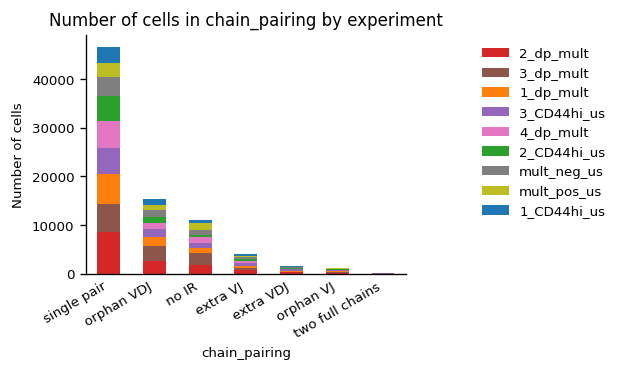

In [12]:
ir.tl.chain_qc(adata)
ax=ir.pl.group_abundance(adata, groupby='chain_pairing', target_col='experiment')
adata = adata[adata.obs["has_ir"] != 'None',:].copy()
adata = adata[~adata.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ"]), :].copy()
print(adata.n_obs)
#adata = adata[adata.obs.index.isin(reactive_cell_barcodes)].copy()
#print(adata.n_obs)

Annotate TCR clonotypes and calculate sharedness, adata needs to be split afterwards again, since gene expression profiling is not integratable (different sequencing depths among samples)

## Clonotype integration

Nucleotide identification (not used for downstream analysis)

In [13]:
ir.pp.ir_dist(adata, inplace=True, metric='identity', sequence='nt', key_added='dist_nt_identity', cutoff=0)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only", 
                        same_v_gene=True, key_added='clone_id_nt', n_jobs=15)

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
ir_dist for sequence='nt' and metric='identity' not found. Computing with default parameters.
Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:02)
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


  0%|          | 0/20241 [00:00<?, ?it/s]

--> Done computing clonotype x clonotype distances.  (0:00:27)
Stored clonal assignments in `adata.obs["clone_id_nt"]`.


Amino acid identification - TCR identity is defined by identical amino acid sequence and identical TCR gene framework (Annotation used for downstream analysis)

In [14]:
ir.pp.ir_dist(adata, inplace=True, metric='identity', sequence='aa', key_added='dist_aa_identity', cutoff=0)
ir.tl.define_clonotype_clusters(adata, metric="identity", receptor_arms = 'all', sequence="aa", dual_ir = 'primary_only',
                                key_added='clone_id_aa',
                                distance_key='dist_aa_identity' , same_v_gene=True,n_jobs=15)

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:01)
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


  0%|          | 0/19498 [00:00<?, ?it/s]

--> Done computing clonotype x clonotype distances.  (0:00:23)
Stored clonal assignments in `adata.obs["clone_id_aa"]`.


Size per donor

Export clone information

In [15]:
adata.obs['cell_barcode'] = adata.obs.index

In [16]:
pd.DataFrame(adata.obs).to_csv(save_csv + 'clone_obs_df.csv', index=True)

### Split adata for batch correction and gex analysis

Single cells from Straub et al. 2023 are removed from further analysis, since GEX could not be harmonized between data

In [17]:
adata_merged = adata.copy()

In [18]:
dpmult_list = ['1_dp_mult','2_dp_mult','3_dp_mult','4_dp_mult']
adata = adata_merged[adata_merged.obs.experiment.isin(dpmult_list)].copy()
adata2 = adata_merged[~adata_merged.obs.experiment.isin(dpmult_list)].copy()

In [19]:
adata_file = 'adata_dp_mult_preproc.h5ad'
adata.write(adata_directory+adata_file)

In [21]:
adata.n_obs

28822

## GEX normalization and feature selection: novel sequencing data

Annotate clone size per donor (compared to across whole data set)

In [22]:
adata.obs['clone_id_aa_size_mouse']=adata.obs.clone_id_aa_size

all_clones = adata.obs.clone_id_aa[adata.obs.clone_id_aa_size>1].unique().tolist()
exp_list = adata.obs.experiment.unique().tolist()
exp_group_list = adata.obs.exp_group.unique().tolist()
mouse_list = adata.obs.mouse.unique().tolist()

for i, mouse in enumerate(mouse_list):
    print(str(i+1), end="\r", flush=True)
    donor_list = adata.obs[adata.obs.mouse==mouse].clone_id_aa.unique().tolist()
    clone_list = [x for x in donor_list if x in all_clones]
    for clonotype in clone_list:
        adata.obs.clone_id_aa_size_mouse[np.logical_and(adata.obs.mouse==mouse,adata.obs.clone_id_aa==clonotype)] = adata.obs.clone_id_aa[np.logical_and(adata.obs.mouse==mouse,adata.obs.clone_id_aa==clonotype)].value_counts()[0]

        

80

Sharedness of clonotypes

In [23]:
df_shared = adata.obs.groupby('clone_id_aa').agg(
    shared_mouse = ('mouse','nunique'),
    clonotype = ('clone_id_aa','first'),
)
df_shared = df_shared.dropna()
df_shared = df_shared[df_shared.shared_mouse>1]
df_shared = df_shared.reset_index()

adata.obs['shared_mouse']=1
for clonotype in df_shared.clonotype.tolist():
    adata.obs.shared_mouse[adata.obs.clone_id_aa==clonotype] = df_shared.loc[df_shared.clonotype==clonotype, 'shared_mouse'].item()
    

Reactive clonotypes

In [24]:
clone_list = adata.obs.clone_id_aa[adata.obs.specificity=='reactive'].unique().tolist()
adata.obs.specificity[adata.obs.clone_id_aa.isin(clone_list)] = 'reactive'

Normalize clone size per mouse

In [25]:
%%time
#size factor normalization:

#mean siinfekl reactive size over each donor
mean_size = adata.obs.mouse[adata.obs.specificity=='reactive'].value_counts().mean()
mouse_list = adata.obs.mouse.unique().tolist()
size_factor_list = []

for mouse in mouse_list:
    #individual siinfekl reactive repertoire size
    donor_size = adata.obs.mouse[np.logical_and(adata.obs.specificity=='reactive',adata.obs.mouse==mouse)].value_counts()[0]
    size_factor = donor_size/mean_size
    size_factor_list.append(size_factor)

# get size factors    
d = {'mouse':mouse_list, 'size_factor':size_factor_list}
df = pd.DataFrame(data=d) 

adata.obs['norm_clone_id_aa_size_mouse'] = adata.obs.clone_id_aa_size_mouse

# annotate normalized clone counts
for i, mouse in enumerate(mouse_list):
    size_factor = size_factor_list[i]
    adata.obs.norm_clone_id_aa_size_mouse[adata.obs.mouse==mouse] = adata.obs.norm_clone_id_aa_size_mouse[adata.obs.mouse==mouse] / size_factor
    
    


CPU times: total: 234 ms
Wall time: 231 ms


Annotate clone ranks

In [26]:
%%time
adata.obs['clone_id_aa_rank'] = -1

mouse_list = adata.obs.mouse.unique().tolist()
for mouse in mouse_list:
    df = adata.obs[adata.obs.mouse==mouse][['clone_id_aa','clone_id_aa_size_mouse','specificity']]
    df = df.dropna()
    df['ranking'] = df['clone_id_aa_size_mouse'].rank(ascending=False, method='dense')
    
    adata.obs.clone_id_aa_rank[adata.obs.mouse==mouse] = df.ranking

CPU times: total: 391 ms
Wall time: 382 ms


## Normalization

In [27]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:00)


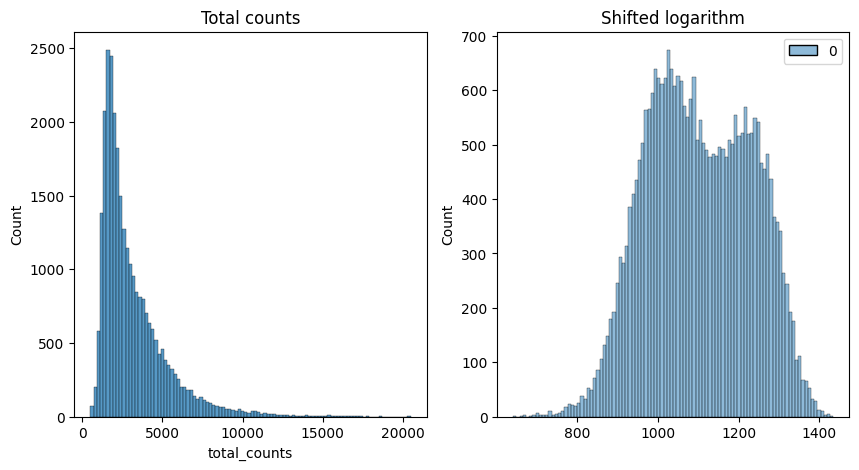

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

## Feature selection

In [29]:
# Exclude TCR genes from the list of highly variable genes
tcr_genes = [gene for gene in adata.var_names if gene.startswith('Trav') or gene.startswith('Traj') or gene.startswith('Trbv') or 
             gene.startswith('Trbj') or gene.startswith('Trbd')]

# Exclude Ribosomal genes from the list of highly variable genes
rib_genes = [gene for gene in adata.var_names if gene.startswith('Rpl') or gene.startswith('Rps') or gene.startswith('Hist') or 
             gene.startswith('Mt-')]

adata = adata[:, ~adata.var_names.isin(tcr_genes)].copy()
adata = adata[:, ~adata.var_names.isin(rib_genes)].copy()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
hvg_list = adata.var_names[adata.var['highly_variable']==True].tolist()
print(str(len(hvg_list)) + ' hvgs')
tcr_in_hvg = [gene for gene in hvg_list if gene in tcr_genes]
print(str(len(tcr_in_hvg)) + ' tcr genes in hvgs')

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
3000 hvgs
0 tcr genes in hvgs


Remove tcr genes from hvgs and clustering

In [30]:
adata.var['highly_variable'] = adata.var['highly_variable'] & ~adata.var_names.isin(tcr_genes)
hvg_list = adata.var_names[adata.var['highly_variable']==True].tolist()
tcr_in_hvg = [gene for gene in hvg_list if gene in tcr_genes]
print(str(len(tcr_in_hvg)) + ' tcr genes in hvgs')

0 tcr genes in hvgs


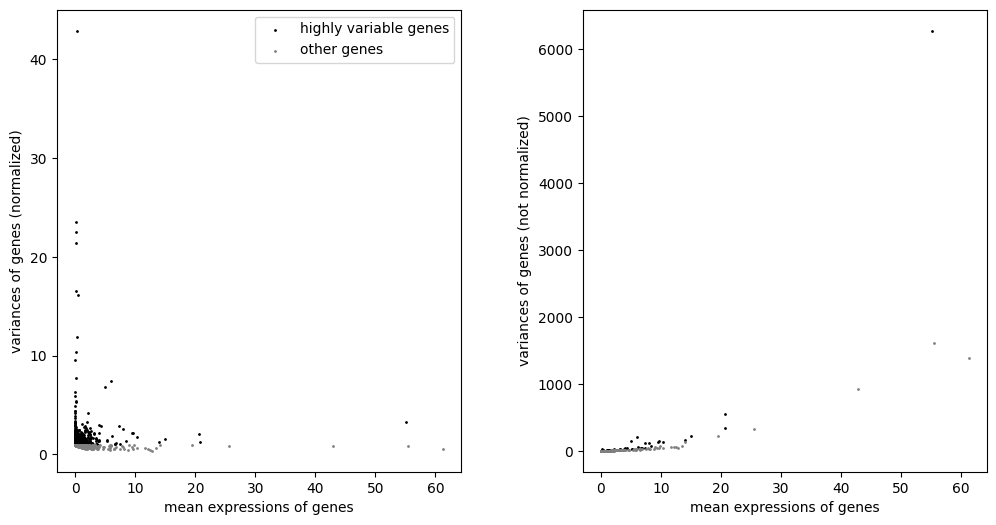

In [31]:
sc.pl.highly_variable_genes(adata)

Set on hvgs

In [32]:
adata = adata[:, adata.var.highly_variable].copy()

## Dimensionality reduction and data integration

computing PCA
    with n_comps=50
    finished (0:00:07)


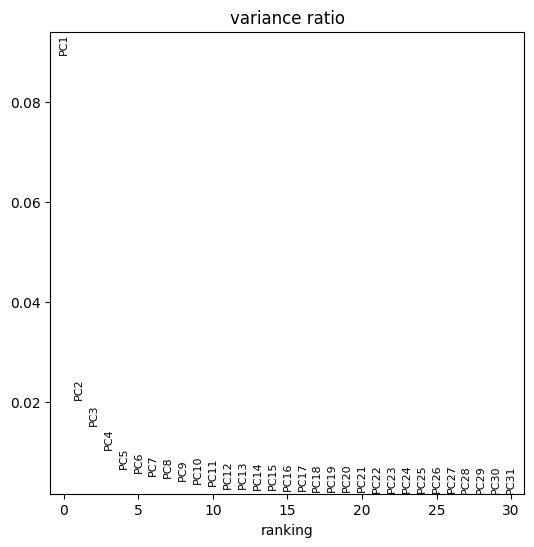

In [33]:
adata.X = adata.layers["log1p_norm"]

sc.pp.pca(adata, n_comps=50)
sc.pl.pca_variance_ratio(adata)

Plot UMAP

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)


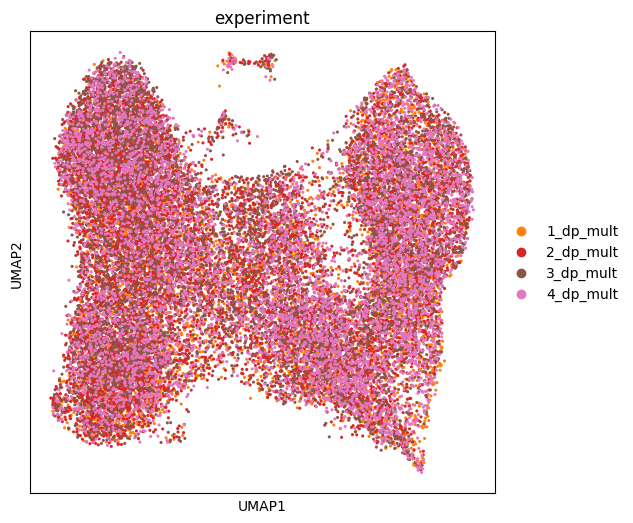

In [34]:
sc.pp.neighbors(adata, n_pcs=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color='experiment', s = 20)

Batch correction

In [35]:
import scvi


batch_key = 'experiment'

scvi.model.SCVI.setup_anndata(adata, layer="soupx_counts", batch_key=batch_key)
model_scvi = scvi.model.SCVI(adata)
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
print(max_epochs_scvi)
#start training
model_scvi.train(early_stopping=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


278


Training:   0%|          | 0/278 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=278` reached.


Recalculate UMAP

In [36]:
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)


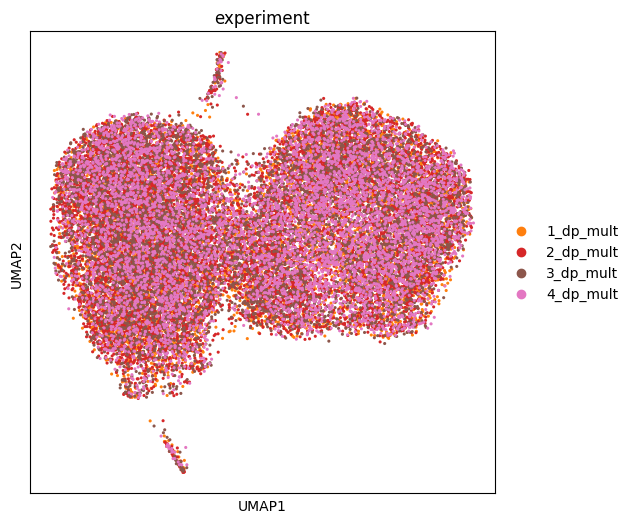

In [37]:
sc.pl.umap(adata, color='experiment', s = 20)

Make backup

In [38]:
adata_dpmult = adata.copy()
adata_file = 'adata_dpmult_batch_updated.h5ad'
adata.write(adata_directory+adata_file)